In [302]:
"""Contains function for importing and handling knockout RNAseq data"""
from os.path import join, dirname
import pandas as pd

def importRNAseqKO():
    data = pd.read_csv("data/rpmCounts_allRuns_matrix.tsv.xz", index_col="GeneSymbol", delim_whitespace = True)
    data = data.drop(["gene_id"], axis=1) # using GeneSymbol as index
    data = data.dropna(axis=1) # remove columns with no measurements
    KO_genes = list(list(zip(*data.columns.str.split("-")))[0])
    data.columns = KO_genes
    return data

In [464]:
data = importRNAseqKO()
data_combined = data.groupby(by=data.columns, axis=1).mean()
data_combined = data_combined.groupby(["GeneSymbol"]).max()
data_combined['neg'] = data_combined[['neg01', 'neg10']].mean(axis=1)
for i in range(1, 10):
    data_combined = data_combined.drop(["neg0"+str(i)], axis=1)
data_combined = data_combined.drop(["neg10"], axis=1)
data_combined = data_combined.drop(["WT"], axis=1)

In [473]:
data_combined.columns

Index(['ADCK3', 'BRD2', 'BRD8', 'BUB1B', 'CBFB', 'CDK11B', 'CHD7', 'CHEK1',
       'CLK1', 'CSK', 'CSNK2A2', 'DEAF1', 'DOT1L', 'DSTYK', 'DYRK1A', 'EGFR',
       'EP300', 'FEZF2', 'FOSL1', 'FOXC2', 'GATA4', 'GFI1', 'GLI4', 'HOXB6',
       'INO80', 'IRF7', 'JUN', 'JUNB', 'KDM1A', 'KDM2A', 'KLF6', 'KMT2D',
       'LATS2', 'LHX1', 'MAFA', 'MAP2K7', 'MAP3K1', 'MAPK1', 'MAPKAPK2',
       'MITF', 'MTF1', 'MYBL1', 'NFAT5', 'NFATC2', 'NFYA', 'NR1I2', 'NSD1',
       'PBRM1', 'PKN2', 'PLK1', 'PLK2', 'POLR2A', 'PRKAA1', 'PRKCE', 'PRKRIR',
       'PRPF4B', 'PTK2', 'RAF1', 'RELB', 'RIPK2', 'RPL9', 'RUNX3', 'SETD1B',
       'SIX5', 'SOX10', 'SOX5', 'SP1', 'SRC', 'SRF', 'STK11', 'SUV420H1',
       'TADA2B', 'TGIF1', 'THAP11', 'TLK2', 'TP73', 'VDR', 'VEZF1', 'YBX1',
       'ZBTB17', 'ZEB2', 'ZFP57', 'ZFX', 'neg'],
      dtype='object')

In [474]:
data_combined.loc["FOSL1","FOSL1"]

41.598021711545776

In [304]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
import numpy as np
%matplotlib inline

#------------------------- Perform PCA using sklearn
def pca(data,num_components):
    "Function takes in parameter for number of components. Returns list containing: [PCA object, fitted model]"
    pca = PCA(n_components=num_components)
    X_r = pca.fit(normalize(data)).transform(data)
    return [pca, X_r]

#-------------------------- Calculate cumulative variance based on number of PCs included and create r2x plot
def r2x(num_components, pca):
    """Function creates r2x plot comparing number of components to % variance captured.
    Parameters include: number of components, pca object from pca()"""
    total_variance = np.array([])
    tot = 0.0
    for i in range(0,num_components):
        tot += pca.explained_variance_ratio_[i]
        total_variance = np.append(total_variance, tot)

    fig = plt.figure(figsize = (8,8))
    ax = plt.subplot(111) 
    ax.set_xlabel("Number of PCs", fontsize = 15)
    ax.set_ylabel("% Variance", fontsize = 15)
    plt.xticks(np.arange(num_components+1))
    plt.plot(list(range(1,num_components+1)),total_variance)
    ax.grid()
    plt.title("r2x Plot", fontsize = 18)
    

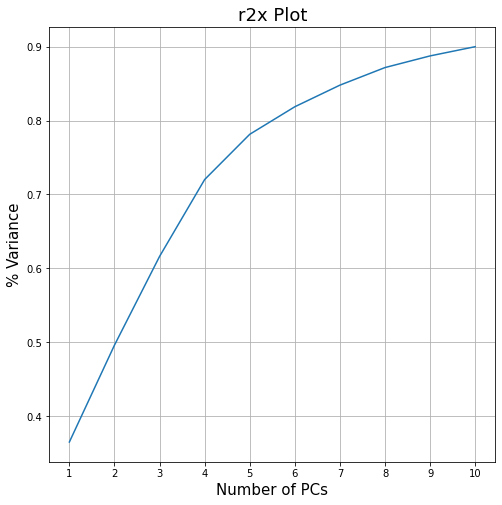

In [354]:
pca_list = pca(data.T,10)
r2x(10, pca_list[0])
X_r = pca_list[1]
KO_genes = data.columns
KO_genes_unique = list(set(KO_genes))
df = pd.DataFrame(X_r)
df["KO Gene"] = KO_genes

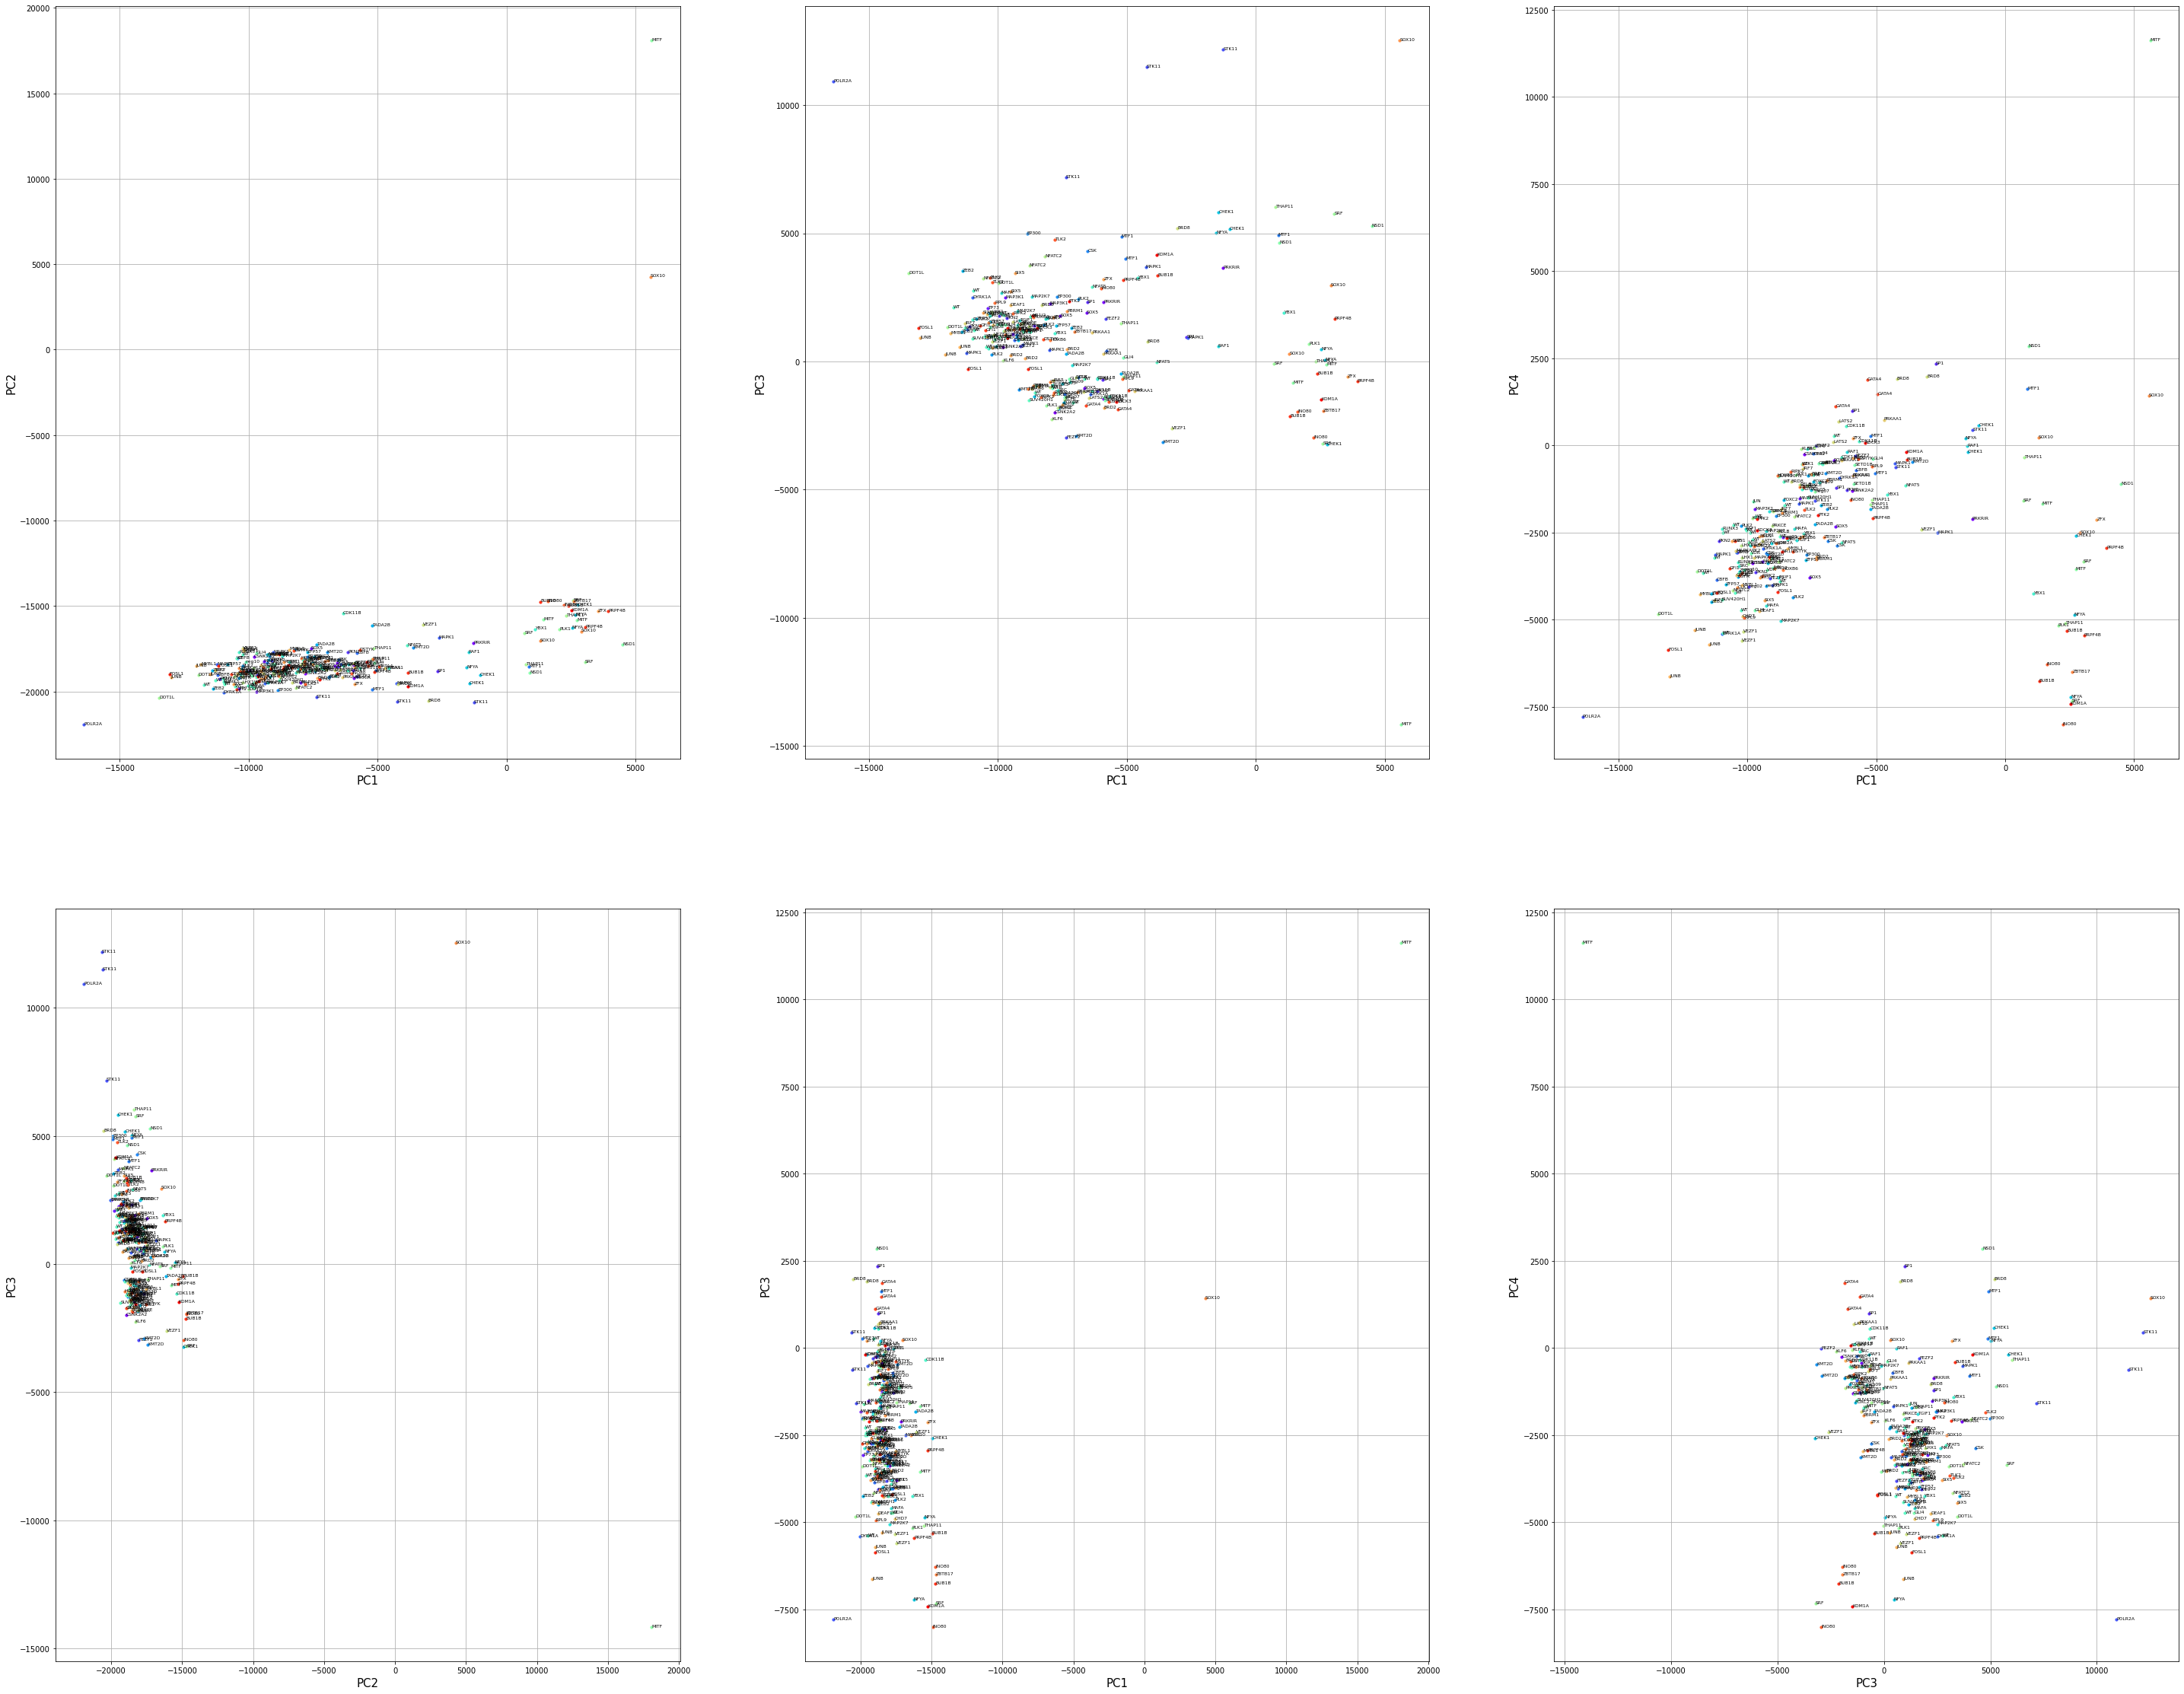

In [355]:
import matplotlib.colors as colors
import matplotlib.cm as cmx

#-------------------------- Create PC plots

# Set the color map to match the number of species
z = range(1,len(KO_genes_unique))
rainbow = plt.get_cmap('rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=len(KO_genes_unique))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=rainbow)

fig = plt.figure(figsize=(50,40))
# PC1 vs PC2
ax = plt.subplot(231)
ax.set_xlabel("PC1", fontsize = 15)
ax.set_ylabel("PC2", fontsize = 15)
for i in range(len(KO_genes_unique)):
    indx = df["KO Gene"] == KO_genes_unique[i]
    plt.scatter(df.iloc[:,0][indx], df.iloc[:,1][indx], s=10, color=scalarMap.to_rgba(i), label=KO_genes_unique[i])
ax.grid()
for i, txt in enumerate(KO_genes):
    ax.annotate(txt, (df.iloc[i,0], df.iloc[i,1]), fontsize=6)

# PC1 vs PC3
ax = plt.subplot(232)
ax.set_xlabel("PC1", fontsize = 15)
ax.set_ylabel("PC3", fontsize = 15)
for i in range(len(KO_genes_unique)):
    indx = df["KO Gene"] == KO_genes_unique[i]
    plt.scatter(df.iloc[:,0][indx], df.iloc[:,2][indx], s=10, color=scalarMap.to_rgba(i), label=KO_genes_unique[i])
ax.grid()
for i, txt in enumerate(KO_genes):
    ax.annotate(txt, (df.iloc[i,0], df.iloc[i,2]), fontsize=6)

# PC1 vs PC4
ax = plt.subplot(233)
ax.set_xlabel("PC1", fontsize = 15)
ax.set_ylabel("PC4", fontsize = 15)
for i in range(len(KO_genes_unique)):
    indx = df["KO Gene"] == KO_genes_unique[i]
    plt.scatter(df.iloc[:,0][indx], df.iloc[:,3][indx], s=10, color=scalarMap.to_rgba(i), label=KO_genes_unique[i])
ax.grid()
for i, txt in enumerate(KO_genes):
    ax.annotate(txt, (df.iloc[i,0], df.iloc[i,3]), fontsize=6)

# PC2 vs PC3
ax = plt.subplot(234)
ax.set_xlabel("PC2", fontsize = 15)
ax.set_ylabel("PC3", fontsize = 15)
for i in range(len(KO_genes_unique)):
    indx = df["KO Gene"] == KO_genes_unique[i]
    plt.scatter(df.iloc[:,1][indx], df.iloc[:,2][indx], s=10, color=scalarMap.to_rgba(i), label=KO_genes_unique[i])
ax.grid()
for i, txt in enumerate(KO_genes):
    ax.annotate(txt, (df.iloc[i,1], df.iloc[i,2]), fontsize=6)

# PC2 vs PC4
ax = plt.subplot(235)
ax.set_xlabel("PC1", fontsize = 15)
ax.set_ylabel("PC3", fontsize = 15)
for i in range(len(KO_genes_unique)):
    indx = df["KO Gene"] == KO_genes_unique[i]
    plt.scatter(df.iloc[:,1][indx], df.iloc[:,3][indx], s=10, color=scalarMap.to_rgba(i), label=KO_genes_unique[i])
ax.grid()
for i, txt in enumerate(KO_genes):
    ax.annotate(txt, (df.iloc[i,1], df.iloc[i,3]), fontsize=6)

# PC3 vs PC4
ax = plt.subplot(236)
ax.set_xlabel("PC3", fontsize = 15)
ax.set_ylabel("PC4", fontsize = 15)
for i in range(len(KO_genes_unique)):
    indx = df["KO Gene"] == KO_genes_unique[i]
    plt.scatter(df.iloc[:,2][indx], df.iloc[:,3][indx], s=10, color=scalarMap.to_rgba(i), label=KO_genes_unique[i])
ax.grid()
for i, txt in enumerate(KO_genes):
    ax.annotate(txt, (df.iloc[i,2], df.iloc[i,3]), fontsize=6)

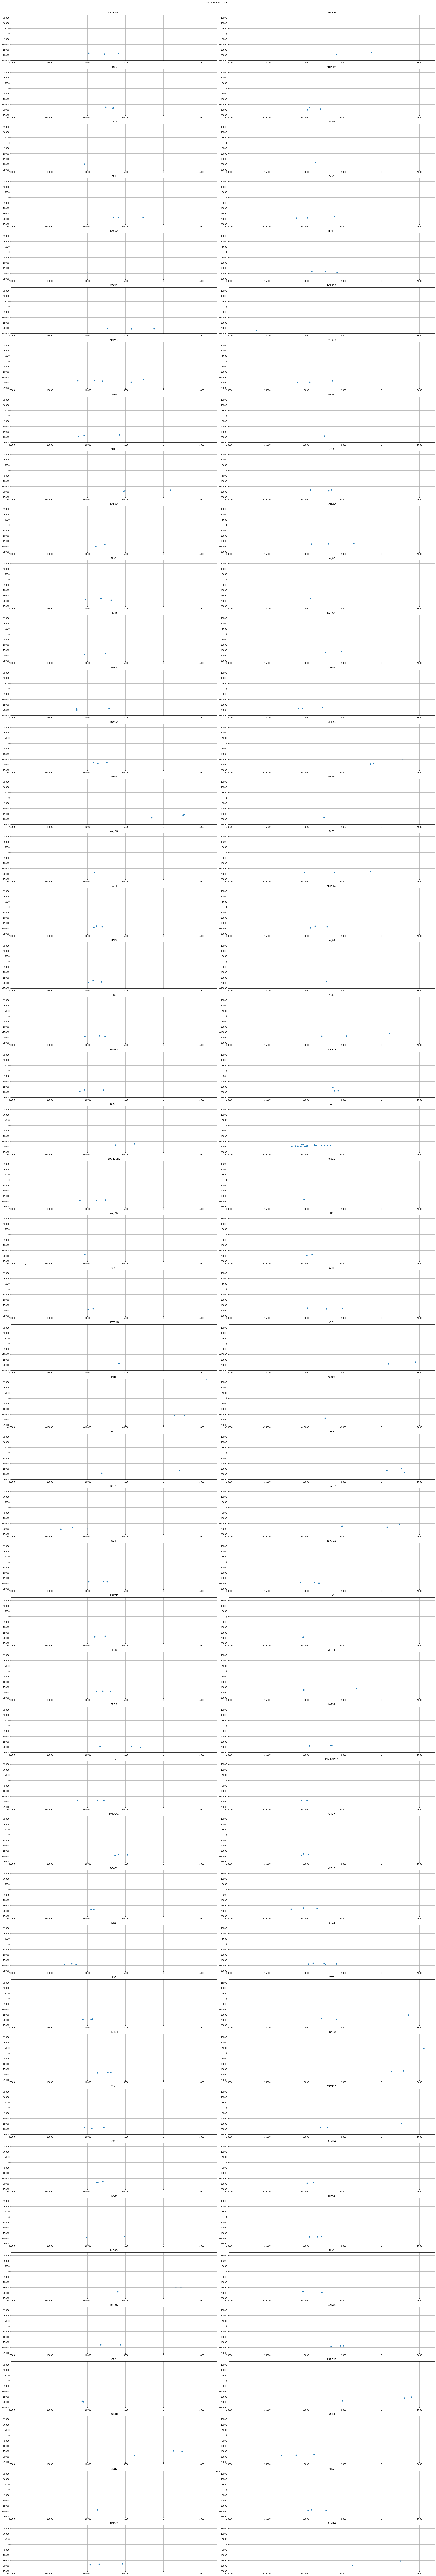

In [356]:
#-------------------------- Plot individual knockouts for PC1 vs PC2
fig, axes = plt.subplots(nrows=47, ncols=2,figsize=(30,180))
fig.suptitle('KO Genes PC1 v PC2')
for ax, name in zip(axes.flatten(), KO_genes_unique):
    indx = df["KO Gene"] == name
    ax.scatter(df.iloc[:,0][indx], df.iloc[:,1][indx], s=30)
    ax.grid()
    ax.set_title(name)
    ax.set_xlim((-20000,7000))
    ax.set_ylim((-25000,18000))
fig = ax.get_figure()
fig.text(0.5, 0.04, 'PC1', ha='center', va='center')
fig.text(0.06, 0.5, 'PC2', ha='center', va='center', rotation='vertical')
fig.tight_layout()
fig.subplots_adjust(top=0.975)
#plt.savefig("PC2vPC1_all.png")

In [357]:
#-------------------------- Analyze spread of replicates' PC scores
PC_KO_spreads = pd.DataFrame(KO_genes_unique, columns=["KO GeneSymbol"])
PC_KO_spreads["Number of Replicates"] = 0
PC_KO_spreads["PC1 Spread"] = 0
PC_KO_spreads["PC2 Spread"] = 0
PC_KO_spreads["PC3 Spread"] = 0
PC_KO_spreads["PC4 Spread"] = 0
PC_KO_spreads["PC5 Spread"] = 0
PC_KO_spreads["PC6 Spread"] = 0
PC_KO_spreads["PC7 Spread"] = 0
PC_KO_spreads["PC8 Spread"] = 0
PC_KO_spreads["PC9 Spread"] = 0
PC_KO_spreads["PC10 Spread"] = 0
PC_KO_spreads = PC_KO_spreads.set_index("KO GeneSymbol")
df

,0,1,2,3,4,5,6,7,8,9,KO Gene
0,-8467.055146,-18440.946865,1300.040248,-2647.020790,-1327.893888,-3020.152694,-1000.881071,-3135.629246,-667.819467,-2926.895594,ADCK3
1,-5417.977325,-18288.193777,-1579.336168,76.992137,-672.179906,-3048.580113,-274.719457,-2060.515318,-1283.580029,-2869.424271,ADCK3
2,-9635.994402,-19139.625276,904.958201,-2448.696175,-1265.839207,-3258.179168,-1540.932949,-2604.293087,-528.690472,-3835.852180,ADCK3
3,-8940.485904,-17843.257082,105.232900,-3524.204140,-1014.589998,-2927.022765,-2101.660157,-3896.715213,-857.511522,-2273.092994,BRD2
4,-7324.415554,-19216.683167,470.210910,-3207.385001,-1006.937640,-2863.243918,-2456.427266,-998.250066,-1650.748240,-5099.712628,BRD2
...,...,...,...,...,...,...,...,...,...,...,...
256,-10827.035257,-18417.098223,1666.461370,-3978.287348,-1392.944929,-3183.620289,-1816.978231,-3830.955748,-750.780533,-2642.626408,ZFP57
257,-10301.645662,-18672.324363,1535.523875,-3606.964702,-1395.600385,-3259.912706,-766.782522,-3085.696306,-986.831576,-3194.152172,ZFP57
258,-7852.670554,-18458.858509,1733.111631,-2610.164909,-1329.517965,-3151.705390,-1113.331709,-3281.226248,-822.423548,-2606.188103,ZFX
259,3555.104201,-15296.462233,-594.445109,-2141.312750,-989.402461,-2169.604273,-982.889654,-3031.012437,1462.707156,-2108.959240,ZFX


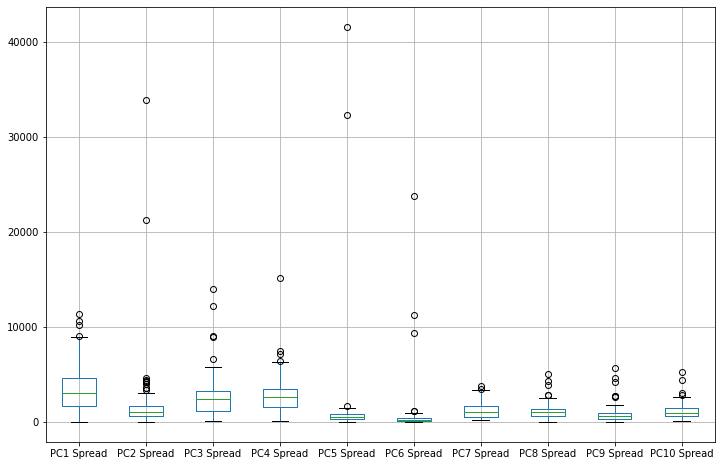

In [359]:
df = df.set_index("KO Gene")
for i in range(1, 11):
    for gene in KO_genes_unique:
        PC_KO_spreads.loc[gene, "PC"+str(i)+" Spread"] = df.loc[gene, (i-1)].max()-df.loc[gene, (i-1)].min()
        PC_KO_spreads.loc[gene, "Number of Replicates"] = df.loc[[gene]].shape[0]

# Remove all single replicate knockout genes and WT
mask = (PC_KO_spreads["Number of Replicates"] > 1)  & (PC_KO_spreads["Number of Replicates"] < 10)
PC_KO_spreads = PC_KO_spreads[mask] 
# Display boxplots of PC spread
boxplot = PC_KO_spreads.boxplot(column=["PC1 Spread", "PC2 Spread", "PC3 Spread", "PC4 Spread",
                                       "PC5 Spread", "PC6 Spread", "PC7 Spread", "PC8 Spread",
                                       "PC9 Spread", "PC10 Spread"], figsize=(12, 8))

In [ ]:
# Calculate 75th percentile for each PC
Q3_1 = PC_KO_spreads["PC1 Spread"].quantile(0.75)
Q3_2 = PC_KO_spreads["PC2 Spread"].quantile(0.75)
Q3_3 = PC_KO_spreads["PC3 Spread"].quantile(0.75)
Q3_4 = PC_KO_spreads["PC4 Spread"].quantile(0.75)

# Find genes with spread above 75th quartile for all 4 PCs:
PC_KO_spreads.loc[(PC_KO_spreads["PC1 Spread"] > Q3_1) & (PC_KO_spreads["PC2 Spread"] > Q3_2)
                  & (PC_KO_spreads["PC3 Spread"] > Q3_3) & (PC_KO_spreads["PC4 Spread"] > Q3_4)]
        # Genes: THAP11, INO80, BUB1B, KDM1A

# Find genes with spread above 75th quartile for at least 3 PCs:
PC_KO_spreads.loc[((PC_KO_spreads["PC1 Spread"] > Q3_1) & (PC_KO_spreads["PC2 Spread"] > Q3_2)
                  & (PC_KO_spreads["PC3 Spread"] > Q3_3)) | ((PC_KO_spreads["PC4 Spread"] > Q3_4)
                  & (PC_KO_spreads["PC2 Spread"] > Q3_2) & (PC_KO_spreads["PC3 Spread"] > Q3_3))
                  | ((PC_KO_spreads["PC1 Spread"] > Q3_1) & (PC_KO_spreads["PC2 Spread"] > Q3_2)
                  & (PC_KO_spreads["PC4 Spread"] > Q3_4)) | ((PC_KO_spreads["PC1 Spread"] > Q3_1)
                  & (PC_KO_spreads["PC3 Spread"] > Q3_3) & (PC_KO_spreads["PC4 Spread"] > Q3_4))]
        # Genes: MAPK1, NFYA, MITF, PLK1, SRF, THAP11, ZFX, SOX10, ZBTB17, INO80, PRPF4B, BUB1B, KDM1A

# Calculate 25th percentile for each PC
Q1_1 = PC_KO_spreads["PC1 Spread"].quantile(0.25)
Q1_2 = PC_KO_spreads["PC2 Spread"].quantile(0.25)
Q1_3 = PC_KO_spreads["PC3 Spread"].quantile(0.25)
Q1_4 = PC_KO_spreads["PC4 Spread"].quantile(0.25)

# Find genes with spread below 25th quartile for all 4 PCs:
PC_KO_spreads.loc[(PC_KO_spreads["PC1 Spread"] < Q1_1) & (PC_KO_spreads["PC2 Spread"] < Q1_2)
                  & (PC_KO_spreads["PC3 Spread"] < Q1_3) & (PC_KO_spreads["PC4 Spread"] < Q1_4)]
        # Genes: VDR, SETD1B, LHX1, MAPKAPK2, DEAF1, JUNB, KDM2A, GATA4
    
# Sum spread over all PCs and sort
PC_KO_spreads["Spread Sum"] = PC_KO_spreads.sum(axis=1) - PC_KO_spreads["Number of Replicates"]
PC_KO_spreads = PC_KO_spreads.sort_values(by=["Spread Sum"], ascending=False)
PC_KO_spreads

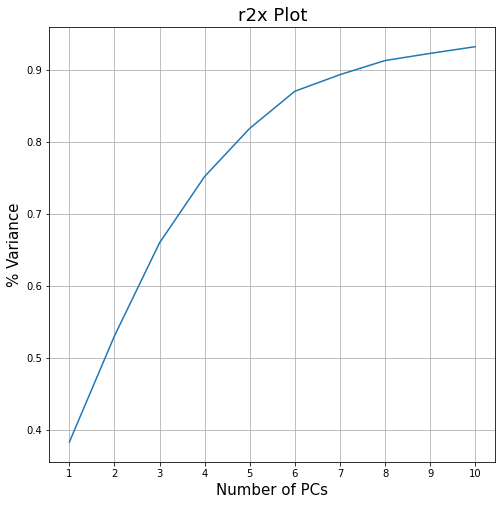

In [367]:
#-------------------------- PCA with replicates averaged together
pca_list_combined = pca(data_combined.T,10)
r2x(10, pca_list_combined[0])
X_r_combined = pca_list_combined[1]

In [368]:
print("Replicates: ", pca_list[0].explained_variance_ratio_)
print("Averaged: ", pca_list_combined[0].explained_variance_ratio_)

Replicates:  [0.36518629 0.13100731 0.11999281 0.10402774 0.06120205 0.03727253
 0.02921478 0.02378599 0.01576471 0.01246734]
Averaged:  [0.38335367 0.1472313  0.12918994 0.09204675 0.06678328 0.05146735
 0.023025   0.01958701 0.00992994 0.00930683]


In [369]:
X_r_combined.shape

(94, 10)

In [370]:
data_combined

,ADCK3,BRD2,BRD8,BUB1B,CBFB,CDK11B,CHD7,CHEK1,CLK1,CSK,...,neg01,neg02,neg03,neg04,neg05,neg06,neg07,neg08,neg09,neg10
GeneSymbol,,,,,,,,,,,,,,,,,,,,,
TSPAN6,29.068544,29.395317,31.840012,26.642511,29.340366,17.162084,26.154362,22.991334,26.585425,26.876934,...,28.522973,26.843404,29.366323,28.823225,26.799821,27.389964,28.966847,29.577702,28.839245,36.401874
TNMD,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
DPM1,77.678236,80.683401,65.397251,137.927807,66.115842,45.287672,70.251727,98.063709,69.705271,76.316445,...,75.547333,72.003483,71.643701,65.135949,73.441816,72.599905,74.374336,63.788055,66.274804,71.347673
SCYL3,13.867477,13.046677,12.559624,11.449325,13.090654,7.515669,13.612045,15.979086,12.461356,8.493269,...,12.719704,12.316385,14.936319,13.163363,14.172982,10.559986,10.960428,15.323388,11.092017,11.648600
C1orf112,14.843737,15.697438,20.012206,19.414879,18.672932,12.685770,15.683543,25.681926,14.941170,11.421466,...,13.490595,13.421702,17.721057,15.432908,19.197948,14.189981,20.616044,16.036103,15.251524,11.163241
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RP11-180C16.1,0.610588,0.296368,0.436900,0.357825,0.613591,0.162007,0.501445,0.369685,0.722505,0.418922,...,0.385446,0.315805,0.759474,0.226955,0.257691,0.659999,0.260963,0.356358,0.554601,0.242679
TSEN34,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
RP11-138A9.2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [371]:
print(data_combined.columns)

Index(['ADCK3', 'BRD2', 'BRD8', 'BUB1B', 'CBFB', 'CDK11B', 'CHD7', 'CHEK1',
       'CLK1', 'CSK', 'CSNK2A2', 'DEAF1', 'DOT1L', 'DSTYK', 'DYRK1A', 'EGFR',
       'EP300', 'FEZF2', 'FOSL1', 'FOXC2', 'GATA4', 'GFI1', 'GLI4', 'HOXB6',
       'INO80', 'IRF7', 'JUN', 'JUNB', 'KDM1A', 'KDM2A', 'KLF6', 'KMT2D',
       'LATS2', 'LHX1', 'MAFA', 'MAP2K7', 'MAP3K1', 'MAPK1', 'MAPKAPK2',
       'MITF', 'MTF1', 'MYBL1', 'NFAT5', 'NFATC2', 'NFYA', 'NR1I2', 'NSD1',
       'PBRM1', 'PKN2', 'PLK1', 'PLK2', 'POLR2A', 'PRKAA1', 'PRKCE', 'PRKRIR',
       'PRPF4B', 'PTK2', 'RAF1', 'RELB', 'RIPK2', 'RPL9', 'RUNX3', 'SETD1B',
       'SIX5', 'SOX10', 'SOX5', 'SP1', 'SRC', 'SRF', 'STK11', 'SUV420H1',
       'TADA2B', 'TGIF1', 'THAP11', 'TLK2', 'TP73', 'VDR', 'VEZF1', 'WT',
       'YBX1', 'ZBTB17', 'ZEB2', 'ZFP57', 'ZFX', 'neg01', 'neg02', 'neg03',
       'neg04', 'neg05', 'neg06', 'neg07', 'neg08', 'neg09', 'neg10'],
      dtype='object')


In [475]:
data_combined = data_combined.sort_index()

ADCK3     140.081297
BRD2      121.078230
BRD8      150.839464
BUB1B     129.678781
CBFB      134.322294
             ...    
ZBTB17    125.312279
ZEB2      133.401130
ZFP57     143.204201
ZFX       143.341708
neg       145.802830
Name: BRD2, Length: 84, dtype: float64

In [489]:
matrix = pd.DataFrame()
for i, gene in enumerate(data_combined.columns):
    if gene != "neg":
        matrix[gene] = data_combined.loc[gene,:]
matrix = matrix.T
matrix

,ADCK3,BRD2,BRD8,BUB1B,CBFB,CDK11B,CHD7,CHEK1,CLK1,CSK,...,TLK2,TP73,VDR,VEZF1,YBX1,ZBTB17,ZEB2,ZFP57,ZFX,neg
ADCK3,57.679527,91.102197,82.016799,53.493974,84.246725,62.812410,89.001858,69.618059,93.447923,83.801517,...,99.310275,78.067567,84.107095,83.592739,74.822172,71.515093,86.562166,82.572853,73.616712,87.623044
BRD2,140.081297,121.078230,150.839464,129.678781,134.322294,91.476897,139.627915,140.848316,145.954195,142.326307,...,143.003183,138.063939,146.119603,158.966740,139.890826,125.312279,133.401130,143.204201,143.341708,145.802830
BRD8,79.121460,92.226625,66.394074,72.758717,95.908005,254.403611,81.859312,76.347791,79.764045,84.988856,...,87.533793,81.681807,78.713282,84.241333,70.899889,72.598672,81.116311,86.493468,90.139914,92.412584
BUB1B,39.209418,29.078304,44.353278,50.433899,44.285747,26.068757,28.093234,51.553671,29.623281,31.934454,...,29.490529,19.516892,32.384691,43.964723,48.203175,46.592248,32.750093,31.579933,48.186743,30.249781
CBFB,124.121903,122.682097,141.153640,221.286543,61.381032,79.576370,113.961529,197.674176,119.299893,129.951607,...,116.643416,93.247372,115.269850,149.385813,142.914489,169.625872,111.263606,116.287757,165.568546,111.812830
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YBX1,829.440732,951.249997,837.224109,1266.999112,765.416936,597.632687,828.646963,984.910289,847.495823,993.162195,...,789.439858,852.237612,820.209163,978.063647,773.706490,1100.111893,876.007950,807.168397,1064.818777,844.824798
ZBTB17,33.293594,31.354877,29.974318,35.244563,32.336334,21.205129,30.348623,41.579422,28.346085,34.063493,...,28.474579,35.419545,30.973932,34.128861,31.128668,23.935873,29.871058,31.788347,34.774057,33.797277
ZEB2,155.072646,150.271224,150.045937,121.133685,179.695718,110.329273,137.906853,125.346640,138.980450,155.201663,...,144.222373,128.666917,136.941299,124.685256,127.978195,132.211114,144.764692,155.359203,155.454811,141.177365
ZFP57,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.105508,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.092201,0.000000,0.000000
